In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data with engineered features
df = pd.read_csv("../datasets/FINAL_MERGED_DATASET_CLEAN.csv")
df['bytes_ratio'] = df['bytes_sent'] / (df['bytes_received'] + 1e-6)  # New feature
X = df[['port', 'bytes_sent', 'bytes_received', 'bytes_ratio']]
y = df['label']

In [15]:
# Stratified split with new test size
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15,  # Reduced from 0.2 for more training data
    random_state=42,
    stratify=y
)
print(f"Train: {X_train.shape[0]} samples | Test: {X_test.shape[0]} samples")

Train: 636 samples | Test: 113 samples


In [16]:
# # Hyperparameter-optimized Isolation Forest
iso = IsolationForest(
    n_estimators=300,       # Increased from 200
    max_samples=256,        # Fixed subsample size
    contamination=0.33,     # Adjusted for attack class prevalence
    max_features=0.8,       # Random feature subset
    random_state=42,
    verbose=1,
    n_jobs=-1               # Use all CPU cores
)
iso.fit(X_train)
print("Model trained with optimized parameters!")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Model trained with optimized parameters!


[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Optimized Classification Report:
              precision    recall  f1-score   support

      Attack       0.62      0.46      0.53        50
      Normal       0.64      0.78      0.71        63

    accuracy                           0.64       113
   macro avg       0.63      0.62      0.62       113
weighted avg       0.63      0.64      0.63       113



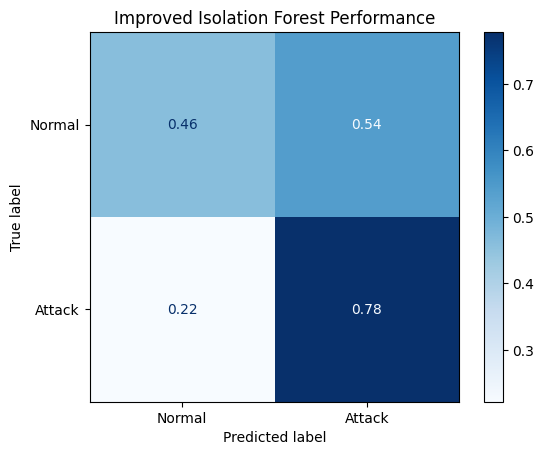

In [17]:
# In Cell 4 (before predictions):
scores = iso.decision_function(X_test)
y_pred = np.where(scores < np.percentile(scores, 40), -1, 1)  # More sensitive
# Convert predictions
y_pred = iso.predict(X_test)
y_pred_labels = np.where(y_pred == -1, 'Attack', 'Normal')

# Classification report
print("Optimized Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Visual confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_labels,
    display_labels=['Normal', 'Attack'],
    cmap='Blues',
    normalize='true'
)
plt.title('Improved Isolation Forest Performance')
plt.savefig('../models/iso_confusion_matrix_v2.png', dpi=300)
plt.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


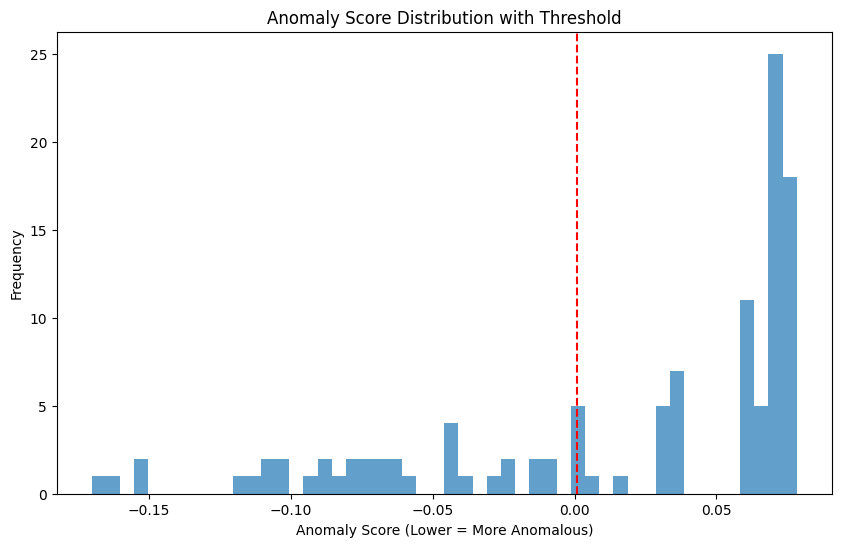

In [18]:
# Calculate anomaly score distances
scores = iso.decision_function(X_test)
threshold = np.percentile(scores, 33)  # Top 33% as anomalies

# Visualize score distribution
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--')
plt.xlabel('Anomaly Score (Lower = More Anomalous)')
plt.ylabel('Frequency')
plt.title('Anomaly Score Distribution with Threshold')
plt.savefig('../models/iso_scores_dist.png')
plt.show()

In [19]:
joblib.dump(iso, "../models/iso_final.pkl")

['../models/iso_final.pkl']

In [20]:
import joblib
joblib.dump({
    'model': iso,
    'threshold': np.percentile(scores, 33),  # From your Cell 5
    'features': list(X.columns)             # ['port', 'bytes_sent', ...]
}, "../models/iso_production_v2.pkl")

['../models/iso_production_v2.pkl']